In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances, accuracy_score
from scipy.spatial.distance import cdist, pdist
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn_lvq import GlvqModel

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib notebook

sns.set(font_scale=2)
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [3]:
def centroids(X,label=None):
    if label is not None:
        cLabel = np.unique(label)
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

In [4]:
def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [5]:
def analyze_prototypes(pr,hv,label,ax,isMain=False):
    allDist = cdist(pr,hv,'hamming')
    
    correctDist = np.array([allDist[x,i] for i,x in enumerate(label)])
    nextDist = [np.min(np.delete(x,label[i])) for i,x in enumerate(allDist.T)]
    
    margin = (nextDist - correctDist)/(correctDist + nextDist)
    
    if isMain:
        sns.kdeplot(correctDist,ax=ax[0],color='k',linestyle=':',linewidth=5)
        sns.kdeplot(margin,ax=ax[1],color='k',linestyle=':',linewidth=5)
    else:
        sns.kdeplot(correctDist,ax=ax[0],linewidth=3,alpha=0.6)
        sns.kdeplot(margin,ax=ax[1],linewidth=3,alpha=0.6)

In [6]:
class LVQHDC(BaseEstimator, ClassifierMixin):
    def __init__(self, initialPrototypes=None, initialPrototypeLabels=None, FPalpha=0.1, FNalpha=0.1, FNdecay=0.99, FPdecay=0.99, maxIter=100, stopTol=0, verbose=False):
        self._prototypes = initialPrototypes
        self._prototypeLabels = initialPrototypeLabels
        self._allPrototypes = None
        self._FPalpha = FPalpha
        self._FNalpha = FNalpha
        self._FPdecay = FPdecay
        self._FNdecay = FNdecay
        self._maxIter = maxIter
        self._stopTol = stopTol
        self._verbose = verbose
        
        self.trainAcc = None
        self.classes = None
        self.valAcc = None
        
        self.D = 0
        
    def fit(self, X, y, grouping=None, imDir=None):
        if self._prototypes is None:
            self._prototypeLabels, self._prototypes = centroids(X,label=y)
            self.classes = np.unique(y)
            self._allPrototypes = [[] for _ in range(len(self.classes))]
            self.D = X.shape[1]
            
        self.trainAcc = []
        for i in range(self._maxIter):
            if imDir is not None:
                f,ax = plt.subplots(1,2,figsize=(20,10))
                for pos in np.unique(grouping):
                     analyze_prototypes(self._prototypes,X[grouping == pos],y[grouping == pos],ax,isMain=False)
                analyze_prototypes(self._prototypes,X,y,ax,isMain=True)
                ax[0].set_xlabel('Hamming distance to correct prototype')
                ax[1].set_xlabel('Hamming distance margin')
                ax[0].set_ylabel('Probability density')
                ax[1].set_ylabel('Probability density')
                ax[0].set_xlim((0,0.55))
                ax[1].set_xlim((-0.25,0.25))
                ax[0].set_ylim((0,25))
                ax[1].set_ylim((0,50))
                plt.savefig(imDir + 'iter_' + str(i) + '.png')
                plt.close(f)
            
            predictions = self._prototypeLabels[classify(X,self._prototypes,'hamming')]
            self.trainAcc.append(accuracy_score(predictions,y))
            if self._verbose:
                print('Iteration %d model fitting accuracy: %f' % (i, self.trainAcc[-1]))
                        
            for g in self.classes:
                self._allPrototypes[g].append(np.copy(self._prototypes[g]))
                
                FNidx = np.where((y == g) & (predictions != g))[0]
                FPidx = np.where((y != g) & (predictions == g))[0]

                FNvec = bipolarize(np.sum(X[FNidx],axis=0))
                FPvec = bipolarize(np.sum(X[FPidx],axis=0))

                FNbits = np.random.choice(self.D,round(self._FNalpha*self.D),replace=False)
                FPbits = np.random.choice(self.D,round(self._FPalpha*self.D),replace=False)

                temp = np.copy(self._prototypes[self._prototypeLabels == g][0])
                temp[FNbits] += FNvec[FNbits]*2
                temp[FPbits] -= FPvec[FPbits]*2
                temp = bipolarize(temp)
                self._prototypes[self._prototypeLabels == g] = np.copy(temp)
                
            self._FPalpha *= self._FPdecay
            self._FNalpha *= self._FNdecay
            
#             if i > 0:
#                 if np.mean(np.diff(self.trainAcc[-10:])) < self._stopTol:
#                     if self._verbose:
#                         print('Stopping condition reached!')
#                         break
            
    def fit_val(self, X, y, XVal, yVal):
        if self._prototypes is None:
            self._prototypeLabels, self._prototypes = centroids(X,label=y)
            self.classes = np.unique(y)
            self._allPrototypes = [[] for _ in range(len(self.classes))]
            self.D = X.shape[1]
            
        self.trainAcc = []
        self.valAcc = []
        for i in range(self._maxIter):
            predictions = self._prototypeLabels[classify(X,self._prototypes,'hamming')]
            self.trainAcc.append(accuracy_score(predictions,y))
            if self._verbose:
                print('Iteration %d model fitting accuracy: %f' % (i, self.trainAcc[-1]))
            
            valPred = self._prototypeLabels[classify(XVal,self._prototypes,'hamming')]
            self.valAcc.append(accuracy_score(valPred,yVal))
            if self._verbose:
                print('Iteration %d model validation accuracy: %f' % (i, self.valAcc[-1]))
                                    
            for g in self.classes:
                self._allPrototypes[g].append(np.copy(self._prototypes[g]))
                
                FNidx = np.where((y == g) & (predictions != g))[0]
                FPidx = np.where((y != g) & (predictions == g))[0]

                FNvec = bipolarize(np.sum(X[FNidx],axis=0))
                FPvec = bipolarize(np.sum(X[FPidx],axis=0))

                FNbits = np.random.choice(self.D,round(self._FNalpha*self.D),replace=False)
                FPbits = np.random.choice(self.D,round(self._FPalpha*self.D),replace=False)

                temp = np.copy(self._prototypes[self._prototypeLabels == g][0])
                temp[FNbits] += FNvec[FNbits]*2
                temp[FPbits] -= FPvec[FPbits]*2
                temp = bipolarize(temp)
                self._prototypes[self._prototypeLabels == g] = np.copy(temp)
                
            self._FPalpha *= self._FPdecay
            self._FNalpha *= self._FNdecay
            
            if i > 0:
                if np.mean(np.diff(self.trainAcc[-10:])) < self._stopTol:
                    if self._verbose:
                        print('Stopping condition reached!')
                        break
            
    def predict(self, X):
        predictions = self._prototypeLabels[classify(X,self._prototypes,'hamming')]
        return predictions
    
    def score(self, X, y):
        predictions = self._prototypeLabels[classify(X,self._prototypes,'hamming')]
        return accuracy_score(predictions,y)
            

In [7]:
# select dataset and encoding type
dataName = 'allHV.npz'
emgHVType =  'hvRelAcc'

allHV = np.load(dataName)

# extract data and labels based on gesture, trial, and position
hv = allHV[emgHVType]
gestLabel = allHV['gestLabel']
posLabel = allHV['posLabel']
trialLabel = allHV['trialLabel']

combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
combGPT, groupGPT = np.unique(np.column_stack((gestLabel,posLabel,trialLabel)),axis=0,return_inverse=True)

# get list of unique values for each label
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

# get data size info
D = hv.shape[1] # hypervector dimension
numHV = 80 # number of examples per trial

# color palettes for plotting
gPalette = sns.color_palette('tab20', numGestures)
pPalette = sns.color_palette('tab20', numPositions)

In [8]:
# numSplit = 20
# skf = StratifiedKFold(n_splits=numSplit)

# X = hv
# y = gestLabel
# c = posLabel
# g = groupGP

# maxIter = 100
# splitIdx = 0

# allAccTrain = np.full_like(np.zeros((maxIter,numGestures,numPositions,numSplit)), np.nan, dtype=np.double)
# centChangeTrain = np.full_like(np.zeros((maxIter,numGestures,numSplit)), np.nan, dtype=np.double)
# centPosChangeTrain = np.full_like(np.zeros((maxIter,numGestures,numPositions,numSplit)), np.nan, dtype=np.double)

# allAcc = np.full_like(np.zeros((maxIter,numGestures,numPositions,numSplit)), np.nan, dtype=np.double)
# centChange = np.full_like(np.zeros((maxIter,numGestures,numSplit)), np.nan, dtype=np.double)
# centPosChange = np.full_like(np.zeros((maxIter,numGestures,numPositions,numSplit)), np.nan, dtype=np.double)

# maxActualIter = 0

# for trainIdx, testIdx in skf.split(X,g):
#     print('Running iteration %d of %d...' % (splitIdx+1, numSplit))
#     XTrain, XTest = X[trainIdx], X[testIdx]
#     yTrain, yTest = y[trainIdx], y[testIdx]
#     cTrain, cTest = c[trainIdx], c[testIdx]
    
#     m = LVQHDC(FPalpha=0.02,FNalpha=0.1,FPdecay=0.9,FNdecay=0.97,maxIter=maxIter,verbose=True)
#     m.fit_val(XTrain, yTrain, XTest, yTest)
    
#     ap = m._allPrototypes
#     numIter = len(ap[0])
#     maxActualIter = max(numIter,maxActualIter)

#     amIters = [[] for _ in range(numIter)]
#     for n in range(numIter):
#         for g in gestures:
#             amIters[n].append(ap[g][n])

#     for g in gestures:
#         for n in range(numIter):
#             pred = classify(XTrain[yTrain == g],np.vstack(amIters[n]),'hamming')
#             cSub = cTrain[yTrain == g]
#             for p in positions:
#                 allAccTrain[n,g,p,splitIdx] = accuracy_score(pred[cSub == p],np.ones(len(pred))[cSub == p]*g)
#             pred = classify(XTest[yTest == g],np.vstack(amIters[n]),'hamming')
#             cSub = cTest[yTest == g]
#             for p in positions:
#                 allAcc[n,g,p,splitIdx] = accuracy_score(pred[cSub == p],np.ones(len(pred))[cSub == p]*g)

        
#         cent = centroids(XTrain,yTrain)[1][g].reshape(1,-1)
#         centPos = centroids(XTrain[yTrain==g],cTrain[yTrain==g])[1]
        
#         centChangeTrain[:numIter,g,splitIdx] = cdist(cent, np.vstack(ap[g]), 'hamming')[0]
#         centPosChangeTrain[:numIter,g,:,splitIdx] = cdist(centPos, np.vstack(ap[g]), 'hamming').T
        
#         cent = centroids(XTest,yTest)[1][g].reshape(1,-1)
#         centPos = centroids(XTest[yTest==g],cTest[yTest==g])[1]
        
#         centChange[:numIter,g,splitIdx] = cdist(cent, np.vstack(ap[g]), 'hamming')[0]
#         centPosChange[:numIter,g,:,splitIdx] = cdist(centPos, np.vstack(ap[g]), 'hamming').T
    
#     splitIdx += 1

In [9]:
# warnings.filterwarnings("ignore")

# sns.set(font_scale=2)
# sns.set_style('white')
# sns.set_context('poster')

# f,ax = plt.subplots(1,3,figsize=(35,10))

# a = allAcc
# ax[0].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2,3))+np.nanstd(a,axis=(1,2,3)),np.nanmean(a,axis=(1,2,3))-np.nanstd(a,axis=(1,2,3)),alpha=0.05)
# ax[0].plot(np.nanmean(a,axis=(1,2,3)))
# a = allAccTrain
# ax[0].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2,3))+np.nanstd(a,axis=(1,2,3)),np.nanmean(a,axis=(1,2,3))-np.nanstd(a,axis=(1,2,3)),alpha=0.05)
# ax[0].plot(np.nanmean(a,axis=(1,2,3)))

# for p in positions:
#     a = allAcc[:,:,p,:]
#     ax[1].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2))+np.nanstd(a,axis=(1,2)),np.nanmean(a,axis=(1,2))-np.nanstd(a,axis=(1,2)),alpha=0.05)
#     ax[1].plot(np.nanmean(a,axis=(1,2)))
#     a = allAccTrain[:,:,p,:]
#     ax[2].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2))+np.nanstd(a,axis=(1,2)),np.nanmean(a,axis=(1,2))-np.nanstd(a,axis=(1,2)),alpha=0.05)
#     ax[2].plot(np.nanmean(a,axis=(1,2)))
    
# ax[0].set_ylim(0,1)
# ax[1].set_ylim(0,1)
# ax[2].set_ylim(0,1)

# ax[0].set_xlim(0,maxActualIter)
# ax[1].set_xlim(0,maxActualIter)
# ax[2].set_xlim(0,maxActualIter)

# ax[0].set_title('Overall accuracy')
# ax[0].legend(['Validation', 'Training'],loc='lower right')
# ax[0].set_xlabel('Iteration')
# ax[0].set_ylabel('Classification Accuracy')

# ax[1].set_title('Validation accuracy by position')
# ax[1].legend(['Pos %d' % x for x in positions],loc='lower right')
# ax[1].set_xlabel('Iteration')
# ax[1].set_ylabel('Classification Accuracy')

# ax[2].set_title('Training accuracy by position')
# ax[2].legend(['Pos %d' % x for x in positions],loc='lower right')
# ax[2].set_xlabel('Iteration')
# ax[2].set_ylabel('Classification Accuracy')

# plt.show()

# warnings.filterwarnings("default")

In [10]:
# warnings.filterwarnings("ignore")

# sns.set(font_scale=2)
# sns.set_style('white')
# sns.set_context('poster')

# for g in gestures:
#     f,ax = plt.subplots(2,3,figsize=(35,24))
#     ax = ax.flatten()

#     a = allAcc[:,g,:,:]
#     ax[0].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2))+np.nanstd(a,axis=(1,2)),np.nanmean(a,axis=(1,2))-np.nanstd(a,axis=(1,2)),alpha=0.05)
#     ax[0].plot(np.nanmean(a,axis=(1,2)))
#     a = allAccTrain[:,g,:,:]
#     ax[0].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1,2))+np.nanstd(a,axis=(1,2)),np.nanmean(a,axis=(1,2))-np.nanstd(a,axis=(1,2)),alpha=0.05)
#     ax[0].plot(np.nanmean(a,axis=(1,2)))

#     for p in positions:
#         a = allAcc[:,g,p,:]
#         ax[1].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#         ax[1].plot(np.nanmean(a,axis=(1)))
#         a = allAccTrain[:,g,p,:]
#         ax[2].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#         ax[2].plot(np.nanmean(a,axis=(1)))

#     ax[0].set_ylim(0,1)
#     ax[1].set_ylim(0,1)
#     ax[2].set_ylim(0,1)

#     ax[0].set_xlim(0,maxActualIter)
#     ax[1].set_xlim(0,maxActualIter)
#     ax[2].set_xlim(0,maxActualIter)

#     ax[0].set_title('Gesture %d accuracy' % g)
#     ax[0].legend(['Validation', 'Training'],loc='lower right')
#     ax[0].set_xlabel('Iteration')
#     ax[0].set_ylabel('Classification Accuracy')

#     ax[1].set_title('Gesture %d validation accuracy by position' % g)
#     ax[1].legend(['Pos %d' % x for x in positions],loc='lower right')
#     ax[1].set_xlabel('Iteration')
#     ax[1].set_ylabel('Classification Accuracy')

#     ax[2].set_title('Gesture %d training accuracy by position' % g)
#     ax[2].legend(['Pos %d' % x for x in positions],loc='lower right')
#     ax[2].set_xlabel('Iteration')
#     ax[2].set_ylabel('Classification Accuracy')
    
#     a = centChange[:,g,:]
#     ax[3].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#     ax[3].plot(np.nanmean(a,axis=(1)))
#     a = centChangeTrain[:,g,:]
#     ax[3].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#     ax[3].plot(np.nanmean(a,axis=(1)))

#     for p in positions:
#         a = centPosChange[:,g,p,:]
#         ax[4].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#         ax[4].plot(np.nanmean(a,axis=(1)))
#         a = centPosChangeTrain[:,g,p,:]
#         ax[5].fill_between(np.arange(maxIter),np.nanmean(a,axis=(1))+np.nanstd(a,axis=(1)),np.nanmean(a,axis=(1))-np.nanstd(a,axis=(1)),alpha=0.05)
#         ax[5].plot(np.nanmean(a,axis=(1)))

#     ax[3].set_ylim(0,0.5)
#     ax[4].set_ylim(0,0.5)
#     ax[5].set_ylim(0,0.5)

#     ax[3].set_xlim(0,maxActualIter)
#     ax[4].set_xlim(0,maxActualIter)
#     ax[5].set_xlim(0,maxActualIter)

#     ax[3].set_title('Gesture %d prototype shift\nrelative to overall centroid' % g)
#     ax[3].legend(['Validation', 'Training'],loc='lower right')
#     ax[3].set_xlabel('Iteration')
#     ax[3].set_ylabel('Hamming distance')

#     ax[4].set_title('Gesture %d prototype shift\nrelative to validation position centroids' % g)
#     ax[4].legend(['Pos %d' % x for x in positions],loc='lower right')
#     ax[4].set_xlabel('Iteration')
#     ax[4].set_ylabel('Hamming distance')

#     ax[5].set_title('Gesture %d prototype shift\nrelative to training position centroids' % g)
#     ax[5].legend(['Pos %d' % x for x in positions],loc='lower right')
#     ax[5].set_xlabel('Iteration')
#     ax[5].set_ylabel('Hamming distance')

#     plt.show()

# warnings.filterwarnings("default")

In [11]:
X = hv
y = gestLabel
g = posLabel
maxIter = 100
m = LVQHDC(FPalpha=0.02,FNalpha=0.1,FPdecay=0.9,FNdecay=0.97,maxIter=maxIter,verbose=True)
m.fit(X,y,grouping=g,imDir='./test/')

ap = m._allPrototypes
numIter = len(ap[0])

amIters = [[] for _ in range(numIter)]
for n in range(numIter):
    for g in gestures:
        amIters[n].append(ap[g][n])

Iteration 0 model fitting accuracy: 0.882973
Iteration 1 model fitting accuracy: 0.921595
Iteration 2 model fitting accuracy: 0.931611
Iteration 3 model fitting accuracy: 0.907853
Iteration 4 model fitting accuracy: 0.938502
Iteration 5 model fitting accuracy: 0.931050
Iteration 6 model fitting accuracy: 0.940905
Iteration 7 model fitting accuracy: 0.932772
Iteration 8 model fitting accuracy: 0.931651
Iteration 9 model fitting accuracy: 0.931971
Iteration 10 model fitting accuracy: 0.945513
Iteration 11 model fitting accuracy: 0.921715
Iteration 12 model fitting accuracy: 0.892788
Iteration 13 model fitting accuracy: 0.904207
Iteration 14 model fitting accuracy: 0.915865
Iteration 15 model fitting accuracy: 0.930649
Iteration 16 model fitting accuracy: 0.924840
Iteration 17 model fitting accuracy: 0.912380
Iteration 18 model fitting accuracy: 0.931490
Iteration 19 model fitting accuracy: 0.929567
Iteration 20 model fitting accuracy: 0.929167
Iteration 21 model fitting accuracy: 0.94655

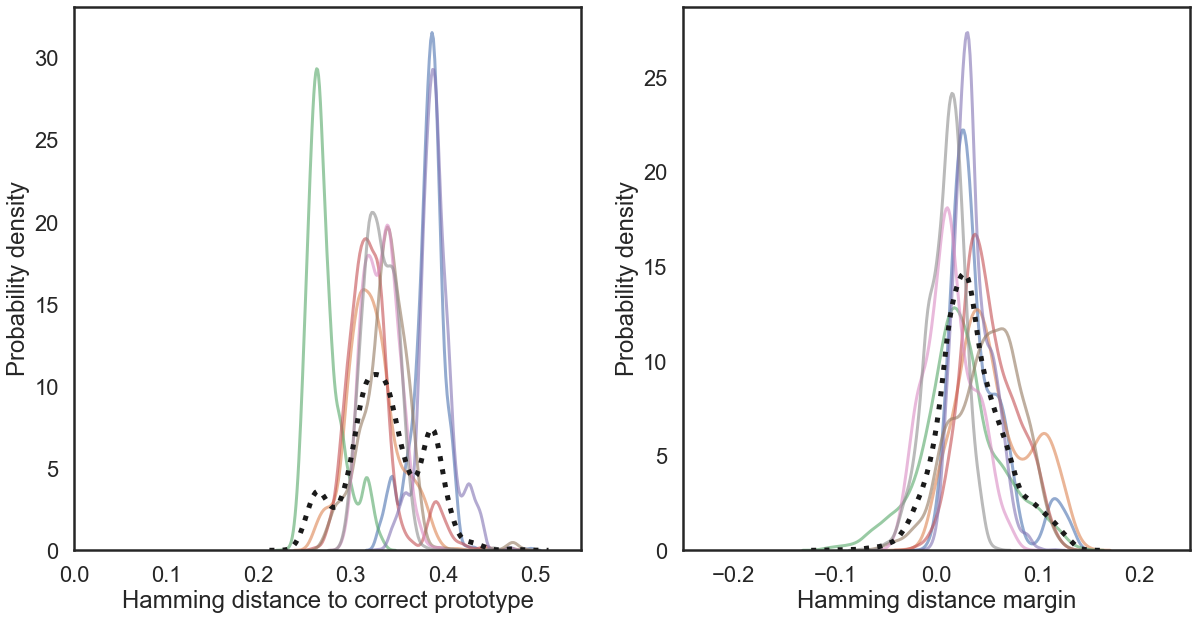

In [12]:
_, centPrototypes = centroids(X,label=y)
prototypes = m._prototypes

f,ax = plt.subplots(1,2,figsize=(20,10))
ax = ax.flatten()
for p in positions:
    analyze_prototypes(centPrototypes,hv[posLabel==p],gestLabel[posLabel==p],ax,isMain=False)
analyze_prototypes(centPrototypes,hv,gestLabel,ax,isMain=True)
ax[0].set_xlabel('Hamming distance to correct prototype')
ax[1].set_xlabel('Hamming distance margin')
ax[0].set_ylabel('Probability density')
ax[1].set_ylabel('Probability density')
    
# analyze_prototypes(centPrototypes,hv,gestLabel,ax)
# analyze_prototypes(prototypes,hv,gestLabel,ax)
ax[0].set_xlim((0,0.55))
ax[1].set_xlim((-0.25,0.25))
plt.show()